In [112]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import warnings
import random
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product




## Approach 1: ARIMA model


In [18]:
# maindf=pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
# maindf['date'] = pd.to_datetime(maindf['Timestamp'],unit='s').dt.date
# group = maindf.groupby('date')
# Real_Price = group['Weighted_Price'].mean()
# Real_Price.info()


[*********************100%%**********************]  1 of 1 completed


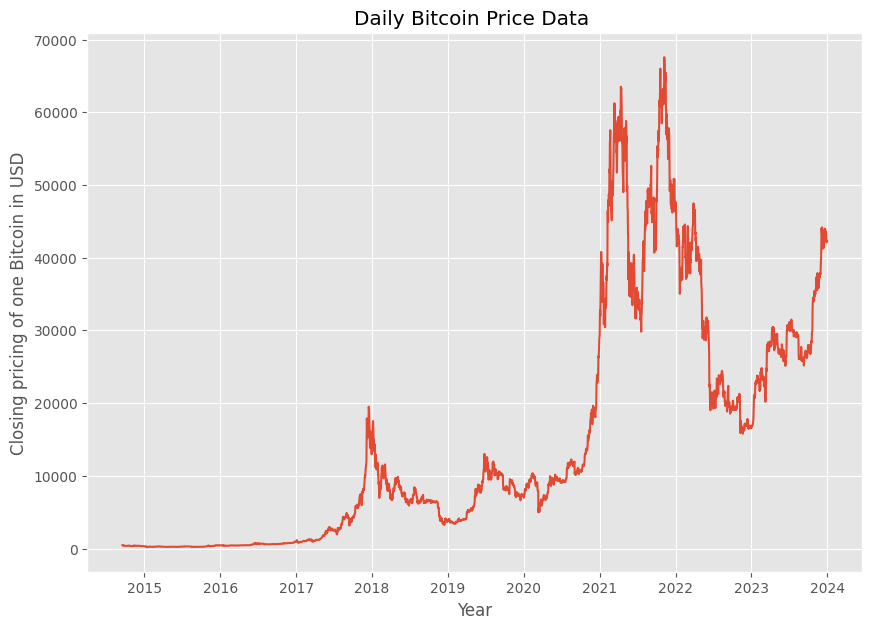

In [19]:
dfbit = yf.download(tickers='BTC-USD', start="2012-01-01", end="2024-01-01")
plt.figure(figsize=(10,7))
plt.xlabel('Year')
plt.ylabel("Closing pricing of one Bitcoin in USD")
plt.title("Daily Bitcoin Price Data ")
plt.plot(dfbit.index, dfbit['Close'])

In [20]:
dfbit.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,42156.902344,16013925945
2023-12-31,42152.097656,42860.937500,41998.253906,42265.187500,42265.187500,16397498810


In [ ]:



print("Root Mean Squared Error (RMSE) of last 30% of data:", rmse_last_30_percent)


Root Mean Squared Error (RMSE): 1215.6248294238437


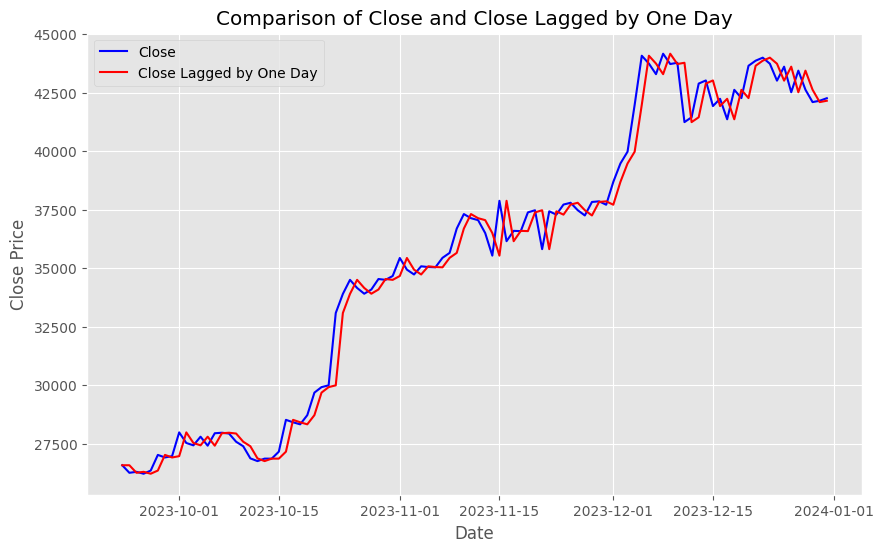

In [119]:
dfbit['Close_Lagged'] = dfbit['Close'].shift(1)
dfbit.dropna(inplace=True)


# Calculate the index where the last 30% of the data starts
last_30_percent_index = int(0.7 * len(dfbit))

# Slice the DataFrame to get the last 30% of the data
last_30_percent_df = dfbit.iloc[last_30_percent_index:]

# Calculate mean squared error between 'Close' and 'Close_Lagged' for the last 30% of the data
mse_last_30_percent = mean_squared_error(last_30_percent_df['Close'], last_30_percent_df['Close_Lagged'])

# Calculate root mean squared error (RMSE) for the last 30% of the data
rmse = np.sqrt(mse_last_30_percent)


print("Root Mean Squared Error (RMSE):", rmse)

# Plot both 'Close' and 'Close_Lagged' columns
plt.figure(figsize=(10, 6))
plt.plot(dfbit['Close'][-100:], label='Close', color='blue')
plt.plot(dfbit['Close_Lagged'][-100:], label='Close Lagged by One Day', color='red')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Comparison of Close and Close Lagged by One Day')
plt.legend()

# Show plot
plt.show()

In [22]:
# split into train and test sets, for hyperparameter tuning we only look at 20% of data points, since it will otherwise take too long, we chose the most recent 20% of the data since that seems to have the most fluctuation

#we then split it into train and test with 70% used for training

def train_test(X,r,perc_split):
    """
    :param X: is the input data
    :param r: the ratio of the data you want to split, useful for hyperparameter tuning
    :param perc_split: is the percentage of you split your train and test
    :return: 
    """
    ind = int(r*len(X.values))
    datanum = X.values[len(X.values)-ind:]
    size = int(r*len(X) * perc_split)
    traindat, testdat = datanum[0:size], datanum[size:len(X)]
    return traindat, testdat

def forwardval(train,test,order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        Armodel = ARIMA(history, order=order)
        Armodel.initialize_approximate_diffuse()
        model_fit = Armodel.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse
    
    

In [23]:
def fitter(train,test,configs):
    best_score, best_cfg = float("inf"), None
    try:
        for combination in tqdm(configs, desc="Loading..."):
            p, d, q = combination
            order = (p, d, q)
            rmse=forwardval(train,test,order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print('ARIMA%s RMSE=%.3f' % (order, rmse))
        print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    except KeyboardInterrupt:
        print("Keyboard interrupt detected. Returning the best configuration found so far.")
    return best_cfg, best_score

In [24]:
plist=[0,1,2,4,6]
# p is the number of lags, the higher this is, the more lags and training will take longer
dlist=[0,1,2,3]
#d; differencing, d is the order of differencing to make it stationary so that time series is stationary (so constant mean, variance etc.)
qlist=[0,1,2,3]
# q is the number of lagged forecast errors included in the prediction equation
# Generate all possible combinations of hyperparameters

combinations = list(product(plist, dlist, qlist,))

# Shuffle the list to ensure randomness
random.shuffle(combinations)


In [8]:
warnings.filterwarnings("ignore")

train, test = train_test(dfbit.Close,0.2,0.70)

best_cfg, best_score = fitter(train,test,combinations)

# Extract the best configuration
print("Best configuration:", best_cfg)
print("Best RMSE:", best_score)

Loading...:   0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 1, 2) RMSE=673.045
ARIMA(0, 3, 2) RMSE=701.399
ARIMA(1, 1, 3) RMSE=673.218
ARIMA(1, 0, 0) RMSE=672.923
ARIMA(6, 3, 2) RMSE=758.648
ARIMA(1, 1, 0) RMSE=673.162
ARIMA(0, 2, 1) RMSE=677.757
ARIMA(4, 0, 2) RMSE=678.698
ARIMA(1, 2, 3) RMSE=671.668
ARIMA(4, 1, 1) RMSE=674.121
ARIMA(2, 1, 3) RMSE=672.974
ARIMA(6, 0, 2) RMSE=684.096
ARIMA(6, 0, 0) RMSE=681.668
ARIMA(1, 3, 1) RMSE=816.227
ARIMA(4, 3, 1) RMSE=743.555
ARIMA(1, 3, 2) RMSE=703.077
ARIMA(6, 2, 2) RMSE=689.137
ARIMA(4, 1, 3) RMSE=676.253
ARIMA(6, 3, 3) RMSE=702.674
ARIMA(0, 0, 0) RMSE=9070.836
ARIMA(6, 1, 2) RMSE=690.952
ARIMA(2, 2, 0) RMSE=783.701
ARIMA(0, 2, 0) RMSE=969.686
ARIMA(4, 2, 2) RMSE=673.498
ARIMA(2, 3, 1) RMSE=769.115
ARIMA(1, 2, 1) RMSE=687.612
ARIMA(2, 1, 0) RMSE=672.459
ARIMA(1, 0, 1) RMSE=679.764
ARIMA(1, 3, 3) RMSE=671.255
ARIMA(0, 1, 2) RMSE=673.091
ARIMA(0, 1, 1) RMSE=673.451
ARIMA(2, 0, 1) RMSE=678.737
ARIMA(4, 3, 0) RMSE=911.978
ARIMA(0, 3, 1) RMSE=970.569
ARIMA(4, 3, 3) RMSE=696.964
ARIMA(2, 2, 2) RMSE

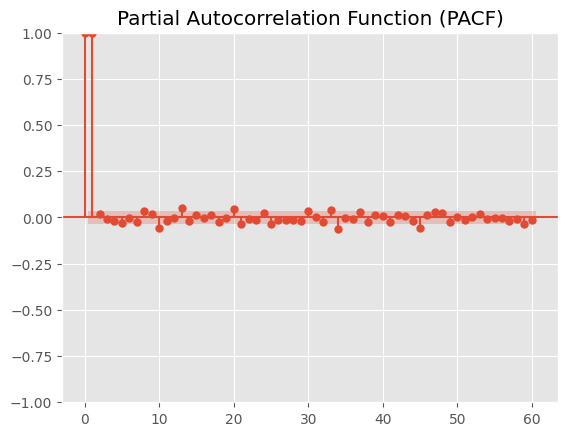

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF
plot_pacf(dfbit.Close, lags=60)  
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

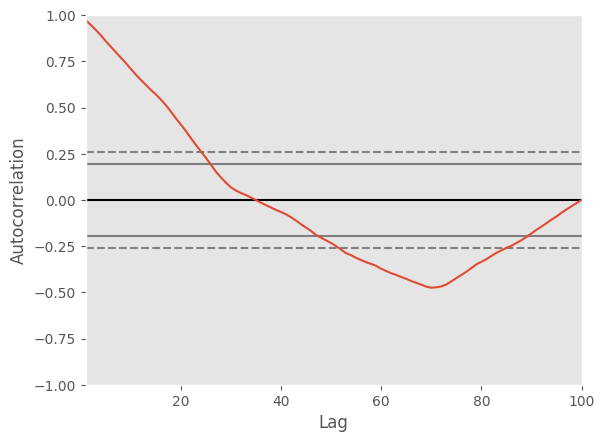

In [26]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

autocorrelation_plot(dfbit.Close[len(dfbit.Close)-100:])
pyplot.show()



In [27]:
#Now we train our actual model with the best configuration

train,test = train_test(dfbit.Close,1,0.70)
best_cfg=(2,2,3)

history = [x for x in train]
predictions = list()
for t in tqdm(range(len(test)),desc='Fitting...'):
    Armodel = ARIMA(history, order=best_cfg)
    Armodel.initialize_approximate_diffuse()
    model_fit = Armodel.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)



Fitting...:   0%|          | 0/1018 [00:00<?, ?it/s]

/Users/Morpheus/PycharmProjects/BayesianML/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Morpheus/PycharmProjects/BayesianML/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Morpheus/PycharmProjects/BayesianML/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Morpheus/PycharmProjects/BayesianML/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

In [32]:
len(predictions)

1018

Test RMSE: 1230.630


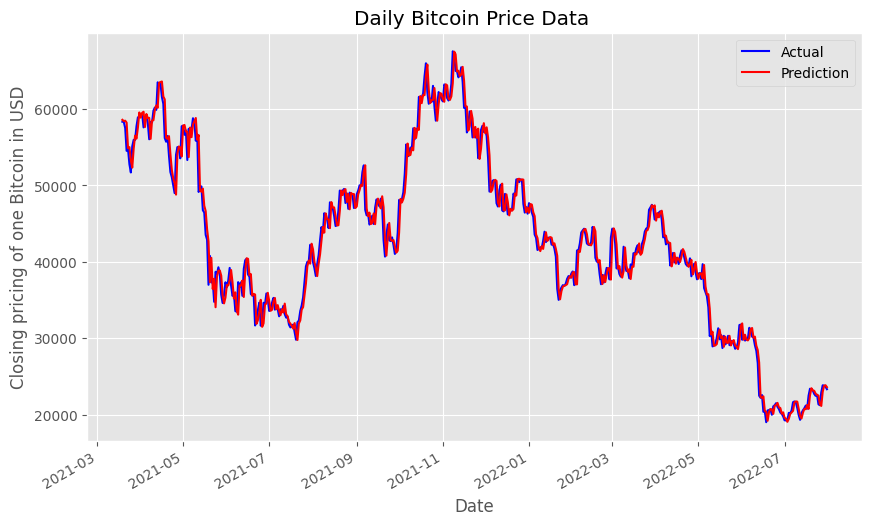

In [99]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pred_days=500
days = dfbit.index[-len(test):]
plt.figure(figsize=(10,6))
plt.gca().figure.autofmt_xdate()
plt.plot(days[:pred_days],test[:pred_days],'b')
plt.plot(days[:pred_days],predictions[:pred_days], 'r')
plt.xlabel('Date')
plt.ylabel("Closing pricing of one Bitcoin in USD")
plt.title("Daily Bitcoin Price Data ")
plt.legend(['Actual','Prediction'])
plt.show()

Looks like just one day lag, in this case its a one step forecast; can only forecast one day in advance given the last x days 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3392
Model:                 ARIMA(2, 2, 3)   Log Likelihood              -27379.772
Date:                Mon, 11 Mar 2024   AIC                          54771.544
Time:                        22:26:00   BIC                          54808.316
Sample:                             0   HQIC                         54784.689
                               - 3392                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9030      0.007   -276.995      0.000      -1.917      -1.890
ar.L2         -0.9713      0.007   -137.825      0.000      -0.985      -0.958
ma.L1          0.8831      0.013     68.251      0.0

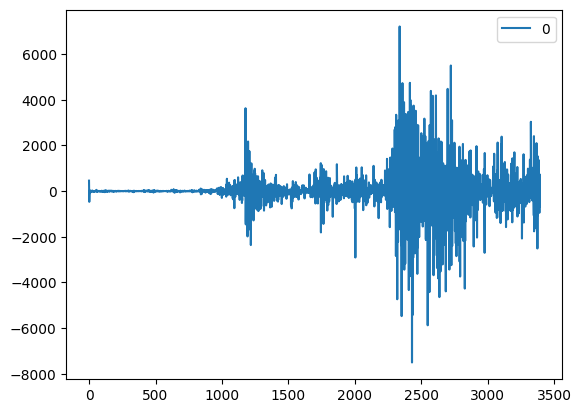

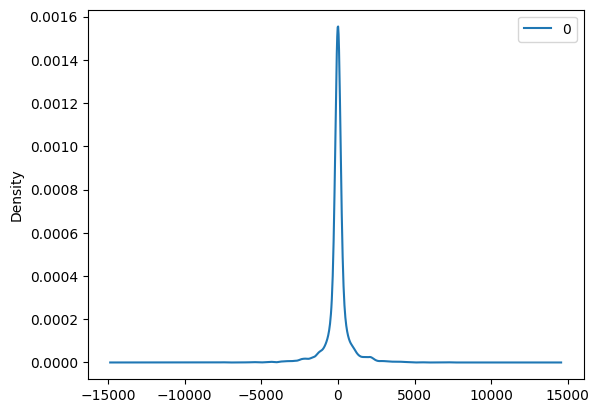

                 0
count  3392.000000
mean      6.168212
std     777.154777
min   -7503.647897
25%     -95.191711
50%       0.769698
75%      99.220619
max    7207.024091


In [15]:
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Approach 2: HMM model

We follow a similar approach as in the computer exercise, and extract three different features; frac_change,frac_high and frac_low
Our aim is to predict the closing price of bitcoin of one day using the opening price and price of the days

In [2]:
dfbit = yf.download(tickers='BTC-USD', start="2012-01-01", end="2024-01-01")
dfbit.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [52]:
ind = int(1*len(dfbit.Close))
datanum = dfbit[len(dfbit.Close)-ind:]
print(0.3*len(dfbit.Close))
datanum

1017.9


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055


In [103]:
%matplotlib inline
from hmmlearn.hmm import GaussianHMM,PoissonHMM,CategoricalHMM
from sklearn.model_selection import train_test_split
import logging
import itertools

class StockPredictor(object):
    def __init__(self, stock_price, test_size=0.30,
                 n_hidden_states=4, n_latency_days=10,
                 n_steps_frac_change=20, n_steps_frac_high=20,
                 n_steps_frac_low=20):
        self._init_logger()

        self.data = stock_price
        self.n_latency_days = n_latency_days

        self.hmm = GaussianHMM(n_components=n_hidden_states)

        self._split_train_test_data(test_size)

        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)

    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)

    def _split_train_test_data(self, test_size):
        data = self.data
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)

        self._train_data = _train_data
        self._test_data = test_data

    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['Open'])
        close_price = np.array(data['Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])

        # Compute the fraction change in close, high and low prices
        # which would be used a feature
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price

        return np.column_stack((frac_change, frac_high, frac_low))

    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vector = StockPredictor._extract_features(self._train_data)
        self._logger.info('Features extraction Completed <<<')

        self.hmm.fit(feature_vector)

    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)

        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))

    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_start_index: previous_data_end_index]
        previous_data_features = StockPredictor._extract_features(
            previous_data)        

        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
        #print(np.argmax(outcome_score))

        #print(most_probable_outcome)
        
        return most_probable_outcome

    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(day_index)
        return open_price * (1 + predicted_frac_change)

    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            predicted_close_prices.append(self.predict_close_price(day_index))
            
        test_data = self._test_data[0: days]
        days = np.array(test_data.index, dtype='datetime64[ms]')
        actual_close_prices = test_data['Close']

        if with_plot:
            

            fig = plt.figure(figsize=(10,6))

            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'b', label='actual')
            axes.plot(days, predicted_close_prices, 'r', label='predicted')

            fig.autofmt_xdate()
            plt.legend()
            plt.xlabel('Date')
            plt.ylabel("Closing pricing of one Bitcoin in USD")
            plt.title("Daily Bitcoin Price Data ")
            plt.show()
            
        RMSE = np.sqrt(1/np.size(actual_close_prices)*np.linalg.norm(actual_close_prices-predicted_close_prices, ord=2)**2)

        return predicted_close_prices, RMSE


In [102]:
ind = int(len(dfbit.Close))
data = dfbit[len(dfbit.Close)-ind:]
print(0.3*len(dfbit.Close))
data.head()

1017.9


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,708 __main__     INFO     >>> Extracting Features
2024-03-26 17:52:55,

  0%|          | 0/100 [00:00<?, ?it/s]

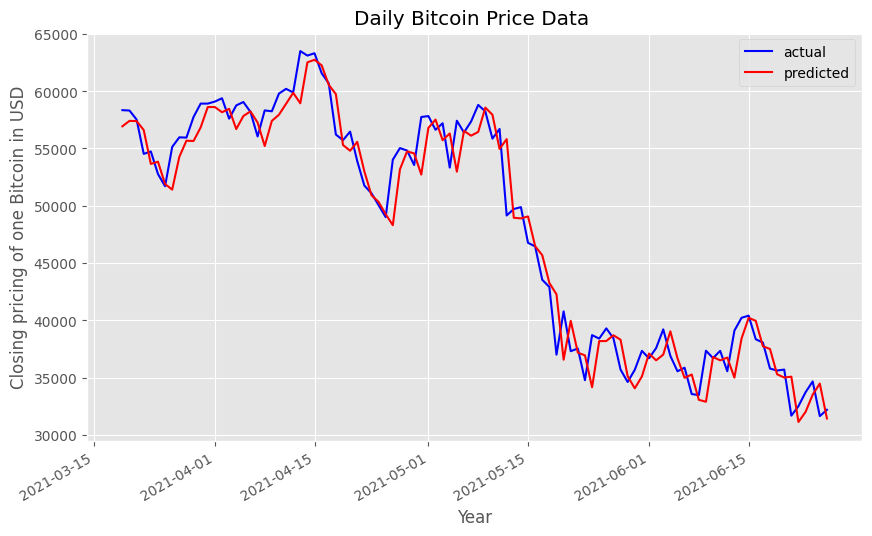

Test RMSE:  2128.212919689864


In [106]:
# Supress warning in hmmlearn
warnings.filterwarnings('ignore')
# Change plot style to ggplot (for better and more aesthetic visualisation)

stock_predictor = StockPredictor(dfbit,n_latency_days=20, n_hidden_states=2)
stock_predictor.fit()
forecasts,RMSE=stock_predictor.predict_close_prices_for_days(100, with_plot=True)
print("Test RMSE: ", RMSE)

In [81]:
ndays=[10,20,30,40,50]
h_states=[2,4,6,8,10]

combinations = list(product(ndays ,h_states))

# Shuffle the list to ensure randomness
random.shuffle(combinations)
best_score, best_cfg = float("inf"),None
for cfg in tqdm(combinations,desc='SIUUUU'):
    n,hs=cfg
    stock_predictor = StockPredictor(datanum,n_latency_days=n, n_hidden_states=hs)
    stock_predictor.fit()
    forecasts, rmse =stock_predictor.predict_close_prices_for_days(10, with_plot=False)
    if rmse < best_score:
        best_score, best_cfg = rmse, cfg
    print('GHMM%s RMSE=%.3f' % (cfg, rmse))
print('Best GHMM%s RMSE=%.3f' % (best_cfg, best_score))
   

    

SIUUUU:   0%|          | 0/25 [00:00<?, ?it/s]

2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,276 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:04,

  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,619 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:15,

GHMM(30, 6) RMSE=694.856


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,840 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:24,

GHMM(30, 4) RMSE=711.784


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,168 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:34,

GHMM(30, 2) RMSE=904.730


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,906 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:43,

GHMM(40, 4) RMSE=874.779


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,179 __main__     INFO     >>> Extracting Features
2024-03-26 16:52:55,

GHMM(10, 6) RMSE=750.413


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,602 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:04,

GHMM(40, 8) RMSE=805.804


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,199 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:14,

GHMM(30, 8) RMSE=857.374


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,505 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:23,

GHMM(20, 2) RMSE=587.985


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,159 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:33,

GHMM(50, 4) RMSE=750.413


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,129 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:43,

GHMM(40, 10) RMSE=694.856


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,542 __main__     INFO     >>> Extracting Features
2024-03-26 16:53:53,

GHMM(50, 10) RMSE=895.239


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,246 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:03,

GHMM(10, 8) RMSE=694.856


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,231 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:13,

GHMM(10, 10) RMSE=750.413


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,822 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:22,

GHMM(20, 4) RMSE=840.868


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,237 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:32,

GHMM(10, 2) RMSE=805.804


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,829 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:41,

GHMM(20, 6) RMSE=615.302


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,956 __main__     INFO     >>> Extracting Features
2024-03-26 16:54:51,

GHMM(30, 10) RMSE=805.804


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,672 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:01,

GHMM(20, 10) RMSE=717.226


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,678 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:11,

GHMM(40, 6) RMSE=694.856


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,638 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:22,

GHMM(40, 2) RMSE=609.697


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,247 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:32,

GHMM(20, 8) RMSE=805.804


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,482 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:41,

GHMM(10, 4) RMSE=823.117


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,809 __main__     INFO     >>> Extracting Features
2024-03-26 16:55:50,

GHMM(50, 6) RMSE=694.856


  0%|          | 0/10 [00:00<?, ?it/s]

2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,452 __main__     INFO     >>> Extracting Features
2024-03-26 16:56:00,

GHMM(50, 8) RMSE=694.856


  0%|          | 0/10 [00:00<?, ?it/s]

GHMM(50, 2) RMSE=805.804
Best GHMM(20, 2) RMSE=587.985
